# Create the DPI Network
1.) Define Thresholds  
2.) Get significant interactions  
3.) Visualize the type and count of interactions  
4.) Create gml file  
5.) Check network parameters (e.g. degree distributions)  
6.) Check adjecency matrix

In [20]:
import numpy as np
from matplotlib import pylab as plt
import networkx as nx
import os

# Certain wells show specific problem that need to be excluded from further analysis
problematic_Well_Signs = ['ProblemWithCombinationWell','CombinationTransferProblem','Drug1Problem','Drug2Problem','CytotoxicDrug1','CytotoxicDrug2','CytotoxicCombination']

#Types of possible interactions
interactionTypes = ['Emergent','Increasing','Decreasing']

#Batches of the screen
batches = ['Batch1','Batch2']


'''
#############
Thresholds###
#############
'''

#Choose the parameter to find an optimal balance between interactions significance and effect size
interaction_significance = 3 #how far away in means of mahalanobis distances from the NI point cloud does the real interaction need to be to be significant
perturbaion_significnace = 7 #how far away in means of mahalanobis distances from DMSO does a perturbation need to be to be significanctly perturbed

AlphaBeta_MAD_range = 2 #range of normal perturbed alpha/beta values per drug for non signifant drug pairs
Gamma_percentile = 100 #range of normal perturbed gamma values per drug for non signifant drug pairs

#Create the corresponding output_folder
output_folder = 'DPI_iS%d_pS%d_abMAD%d_gP%d' %(interaction_significance,perturbaion_significnace,AlphaBeta_MAD_range,Gamma_percentile)
output_path = '../results/Create_DPI_Network/' + output_folder +'/'

#create the directory if it does not exist
directory = os.path.dirname(output_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    os.makedirs(directory+'/Degree_Distributions/')
    os.makedirs(directory+'/Interaction_Images/')
    os.makedirs(directory+'/Networks/')

In [21]:
# Some Easy Outlier detection
def reject_outliers_2(data, m=6.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    #return s < m
    return [data[i] for i in range(0, len(data)) if s[i] < m]


### 1 Create Thresholds
Create thresholds by extracting for all drugs their respective alpha/beta and gamma values belonging to NON significant interactions. Those values then the range of alpha and beta values that a drug can be modulated without significantly changing it. In order to to avoid outliers we used MAD=2 for the alpha/beta values that follow a ca. Gaussian distribution for normal values while for gamma we used a 100 percentile range as the distribution follows more a exponential function with many small values and only some bigger. 

The idea behind this is that smaller effect drugs (having smaller morphological vectors) can be much more changed e.g. 8x while still not resulting in a significant interaction while on the other hand strong effect drugs (with large morphological vectors) already have a strong impact if being changed e.g. 1.1x

In [22]:
#Open the file
fp = open('../data/Create_DPI_Network/All_MC_Scores.csv','r')
fp.next()

#File to save all non-significant alpha/beta/gamma values (to later calculate suited thresholds)
perDrug_AlphaBetaGammas = {'Batch1':{},'Batch2':{}}

#collect all alpha/beta/gammas
for line in fp:
    tmp = line.strip().split(',')
    
    #ignore the drug pair if there seemed to be a problem
    if tmp[5] in problematic_Well_Signs:
        continue
    
    #extract drug and batch information
    drug1 = tmp[0]
    drug2 = tmp[1]
    batch = tmp[2]
    
    #add the drug to the dictionary if not already so
    if perDrug_AlphaBetaGammas[batch].has_key(drug1) == False:
        perDrug_AlphaBetaGammas[batch][drug1] = {'AlphaBetas':[],'Gammas':[]}
    if perDrug_AlphaBetaGammas[batch].has_key(drug2) == False:
        perDrug_AlphaBetaGammas[batch][drug2] = {'AlphaBetas':[],'Gammas':[]}
    
    #get the interaction significance
    maha_General = float(tmp[20])
    #mp_General = float(tmp[22])

    #include only non-significant interactions
    if  maha_General < interaction_significance:
        
        #add the alpha/beta values
        perDrug_AlphaBetaGammas[batch][drug1]['AlphaBetas'].append(float(tmp[14]))
        perDrug_AlphaBetaGammas[batch][drug2]['AlphaBetas'].append(float(tmp[15]))
        
        #add the same gamma to BOTH drugs (as gamma is undirected)
        perDrug_AlphaBetaGammas[batch][drug1]['Gammas'].append(float(tmp[16]))
        perDrug_AlphaBetaGammas[batch][drug2]['Gammas'].append(float(tmp[16]))
fp.close()
        


#Dictionary with the thresholds for each drug        
perDrug_AlphaBetaGammaThresholds = {'Batch1':{},'Batch2':{}}       

#calculate thresholds
for b in batches:
    for key in perDrug_AlphaBetaGammas[b]:

        #create alpha/beta threshold by using the borders of alpha/beta within 2 MADs and gamma within 99 percentiles
        alphaBeta_NoOutlier = reject_outliers_2(perDrug_AlphaBetaGammas[b][key]['AlphaBetas'], AlphaBeta_MAD_range)
        alphaBeta_NoOutlier.append(1)
        perDrug_AlphaBetaGammas[b][key]['Gammas'].append(0)
        perDrug_AlphaBetaGammaThresholds[b][key] = {'Upper':max([x for x in alphaBeta_NoOutlier if x >= 1]), 'Lower':min([x for x in alphaBeta_NoOutlier if x <= 1]), 'Emergent':np.percentile(perDrug_AlphaBetaGammas[b][key]['Gammas'],Gamma_percentile)}

        
plt.hist(perDrug_AlphaBetaGammas['Batch2']['CLOUD057']['AlphaBetas'], bins=10, color = 'grey')
plt.axvline(perDrug_AlphaBetaGammaThresholds['Batch2']['CLOUD057']['Upper'] )
plt.axvline(perDrug_AlphaBetaGammaThresholds['Batch2']['CLOUD057']['Lower'] )
#plt.show()
plt.savefig(output_path + 'Cytarabine_DirectedThreshold.pdf',format='pdf',dpi=600)
plt.close()

plt.hist(perDrug_AlphaBetaGammas['Batch2']['CLOUD057']['Gammas'], bins=10, color = 'grey')
plt.axvline(perDrug_AlphaBetaGammaThresholds['Batch2']['CLOUD057']['Emergent'] )
#plt.show()
plt.savefig(output_path + 'Cytarabine_EmergentThreshold.pdf',format='pdf',dpi=600)
plt.close()

### 2 Get Significant Interactions
Go through all drug pairs and associate significant interactions (effect/sgnificance) correctly to interactions according to our vector math e.g. 1.2 alpha would be a increasing interaction. 

In [23]:
#dictionary with interactions
Interactions = {}

#create the 3 interaction types (increasing, decreasing and emergent)
for iT in interactionTypes:
    Interactions[iT] = {}

#dictionary with significant drug
significant_Drugs = {'Batch1':set(),'Batch2':set()}

#save the perturbation values of the individual drugs
drug_mahalanobis_values = {'Batch1':{},'Batch2':{}}

#Open file with drug pair calculations
fp = open('../data/Create_DPI_Network/All_MC_Scores.csv','r')
fp.next()

#count number of significant interactions (does not nececarry mean final interactions)
InteractionCount = 0
#number of all drug pairs 
Number_Of_Valid_DrugPairs = 0

for line in fp:
    Number_Of_Valid_DrugPairs +=1
    tmp = line.strip().split(',')
    
    #ignore the drug pair if there seemed to be a problem
    if tmp[5] in problematic_Well_Signs:
        continue
    

    #get the interaction significance
    maha_General = float(tmp[20])
    #mp_General = float(tmp[22])
    

    #only check interaction if significantly away from NI point
    if maha_General > interaction_significance:

        #increment significant interaction count
        InteractionCount += 1
        
        #extract drug information
        drug1 = tmp[0]
        drug2 = tmp[1]
        batch = tmp[2]
        
    
        #extract mahalanobis distances (how far away from DMSO)
        maha_drug1 = float(tmp[5])
        maha_drug2 = float(tmp[8])
        maha_Combi = float(tmp[11])
        
        #check for significance (usually > 6)
        drug1_significance = maha_drug1 > perturbaion_significnace
        drug2_significance = maha_drug2 > perturbaion_significnace
        combi_significance = maha_Combi > perturbaion_significnace
        
        #extract alpha/beta/gamma
        alpha = float(tmp[14])
        beta = float(tmp[15])
        gamma =  float(tmp[16])
        
      
        #add drugs to significant drugs if significant
        if drug1_significance:
            significant_Drugs[batch].add(drug1)
        if drug2_significance:
            significant_Drugs[batch].add(drug2)
        
        
        
        drug_mahalanobis_values[batch][drug1] = maha_drug1
        drug_mahalanobis_values[batch][drug2] = maha_drug2
        
        
        #####
        # GOT THROUGH ALL 7 POSSIBILITIES of where a drug can be modulated
        ###
        #0.
        # Singles not active, combination not active ==> no interactions
        
        # 1.)
        #Single not active, combination active ==> possible Emergent
        if drug1_significance == False and drug2_significance == False and combi_significance == True:
            #if gamma > Emergent_Threshold[batch]:
            if gamma > max([perDrug_AlphaBetaGammaThresholds[batch][drug1]['Emergent'],perDrug_AlphaBetaGammaThresholds[batch][drug2]['Emergent']]):
                Interactions['Emergent'][drug1+','+drug2] = {'Value':gamma,'Batch':batch, 'Mahalanobis':maha_General}
        #2.)
        #One Single active, combination active anymore ==> possible Deactivting
        elif drug1_significance == True and drug2_significance == False and combi_significance == False:
            #if alpha < AlphaBeta_Threshold_Decreasing[batch]:
            if alpha < perDrug_AlphaBetaGammaThresholds[batch][drug1]['Lower']:
                Interactions['Decreasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch, 'Mahalanobis':maha_General}
        #3.)
        #One Single active, combination active anymore ==> possible Deactivting
        elif drug1_significance == False and drug2_significance == True and combi_significance == False:
            #if beta < AlphaBeta_Threshold_Decreasing[batch]:
            if beta < perDrug_AlphaBetaGammaThresholds[batch][drug2]['Lower']:
                Interactions['Decreasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch, 'Mahalanobis':maha_General}
        #4.)
        #Both Single active, combination not active anymore ==> possible Double Deactivating
        elif drug1_significance == True and drug2_significance == True and combi_significance == False:
            #if beta < AlphaBeta_Threshold_Decreasing[batch]:
            if beta < perDrug_AlphaBetaGammaThresholds[batch][drug2]['Lower']:
                Interactions['Decreasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch, 'Mahalanobis':maha_General}
            
            if alpha < perDrug_AlphaBetaGammaThresholds[batch][drug1]['Lower']:
                Interactions['Decreasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch, 'Mahalanobis':maha_General}
        
        #5.)
        #One Single active, combination active  ==> The one Single gets modulated
        elif drug1_significance == True and drug2_significance == False and combi_significance == True:
            #print tmp
            #if gamma > Emergent_Threshold[batch]:
            if gamma > max([perDrug_AlphaBetaGammaThresholds[batch][drug1]['Emergent'],perDrug_AlphaBetaGammaThresholds[batch][drug2]['Emergent']]):
                Interactions['Emergent'][drug1+','+drug2] = {'Value':gamma,'Batch':batch, 'Mahalanobis':maha_General}

            if alpha > perDrug_AlphaBetaGammaThresholds[batch][drug1]['Upper']:
                Interactions['Increasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch , 'Mahalanobis':maha_General}

            if alpha < perDrug_AlphaBetaGammaThresholds[batch][drug1]['Lower']:
                Interactions['Decreasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch , 'Mahalanobis':maha_General}
        #6.)
        #One Single active, combination active  ==> The one Single gets modulated
        elif drug1_significance == False and drug2_significance == True and combi_significance == True:
            
            #if gamma > Emergent_Threshold[batch]:
            if gamma > max([perDrug_AlphaBetaGammaThresholds[batch][drug1]['Emergent'],perDrug_AlphaBetaGammaThresholds[batch][drug2]['Emergent']]):
                Interactions['Emergent'][drug1+','+drug2] = {'Value':gamma,'Batch':batch, 'Mahalanobis':maha_General}
            if beta > perDrug_AlphaBetaGammaThresholds[batch][drug2]['Upper']:
                Interactions['Increasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch , 'Mahalanobis':maha_General}
            if beta < perDrug_AlphaBetaGammaThresholds[batch][drug2]['Lower']:
                Interactions['Decreasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch , 'Mahalanobis':maha_General}
        #7.)
        #Both Single active, combination active  ==> Both Single gets modulated
        elif drug1_significance == True and drug2_significance == True and combi_significance == True:
            if gamma > max([perDrug_AlphaBetaGammaThresholds[batch][drug1]['Emergent'],perDrug_AlphaBetaGammaThresholds[batch][drug2]['Emergent']]):
                Interactions['Emergent'][drug1+','+drug2] = {'Value':gamma,'Batch':batch, 'Mahalanobis':maha_General}


            if alpha > perDrug_AlphaBetaGammaThresholds[batch][drug1]['Upper']:
                Interactions['Increasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch , 'Mahalanobis':maha_General}
            if alpha < perDrug_AlphaBetaGammaThresholds[batch][drug1]['Lower']:
                Interactions['Decreasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch , 'Mahalanobis':maha_General}


            if beta > perDrug_AlphaBetaGammaThresholds[batch][drug2]['Upper']:
                Interactions['Increasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch, 'Mahalanobis':maha_General }
            if beta < perDrug_AlphaBetaGammaThresholds[batch][drug2]['Lower']:
                Interactions['Decreasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch, 'Mahalanobis':maha_General }

                
'''
Plot results
'''
        
print 'Theoretical number of pairs: 35.511'
print 'Number investigated drug prais (drug decay, screening problems etc.): %d' %Number_Of_Valid_DrugPairs
print 'Significant Pairs: %d\n' %InteractionCount                
                
NumberOfInteractions = 0      
for iT in interactionTypes:
    print 'Number %s: %d' %(iT , len(Interactions[iT]))
    NumberOfInteractions = NumberOfInteractions + len(Interactions[iT])
print '-------------'
print 'Number of interactions: %d' %NumberOfInteractions


Theoretical number of pairs: 35.511
Number investigated drug prais (drug decay, screening problems etc.): 29826
Significant Pairs: 11961

Number Emergent: 572
Number Increasing: 446
Number Decreasing: 814
-------------
Number of interactions: 1832


### 3 Visualize Results and create output file

In [24]:
print 'Per Batch Results:'
print 'Batch1:'
for iT in interactionTypes:
    print 'Number %s: %d' %(iT , len([x for x in Interactions[iT] if Interactions[iT][x]['Batch'] == 'Batch1']))
print 'Batch2:'
for iT in interactionTypes:
    print 'Number %s: %d' %(iT , len([x for x in Interactions[iT] if Interactions[iT][x]['Batch'] == 'Batch2']))

Per Batch Results:
Batch1:
Number Emergent: 260
Number Increasing: 147
Number Decreasing: 188
Batch2:
Number Emergent: 312
Number Increasing: 299
Number Decreasing: 626


### Create an output file

In [25]:
#Save the significant interaction in a separate file
fp_out = open(output_path+'InteractionsOverview_'+output_folder+'.csv','w')
fp_out.write('Drug1,Drug2,Batch,InteractionType,Value,MahalanobisDistance\n')
for iT in interactionTypes:
    for interaction in Interactions[iT].keys():
        drugs = interaction.split(',')
        fp_out.write(drugs[0]+','+drugs[1]+','+Interactions[iT][interaction]['Batch']+','+iT+','+str(Interactions[iT][interaction]['Value'])+',' +str(Interactions[iT][interaction]['Mahalanobis'])+'\n')
 
fp_out.close()

In [26]:
def CalculatePossibleNumberOfInteractions(network,name):
    
    number_edges = len(network.edges())
    number_nodes = len(network.nodes())
    S = len([x for x in network.nodes() if network.node[x]['OnceSignificant'] == True])        
    N =  number_nodes - S
    
    print 'Number Significant: %d' %S
    print 'Number NonSignificant: %d' %N
    print 'Percent: %.2f' %(float(S)/(S+N))
    
    plt.pie([(float(S)/(S+N)),1 - (float(S)/(S+N))], colors=['#FF9900','#999999'])
    plt.savefig(output_path + name +'_PercentSignificant.pdf',format='pdf',dpi=600)
    plt.close()
    
    PossibleNumberOfInteractions = 3 * (number_nodes*(number_nodes-1)/2)
    PossibleNumberOfInteractions_IncludingNS = 1*(N*(N-1)/2) + 2*N*S + 3*(S*(S-1)/2)
    
    print 'Possible Number Interactions (easy): %d' %PossibleNumberOfInteractions
    print 'Possible Number Interactions (including N/S): %d' %PossibleNumberOfInteractions_IncludingNS
    
    print 'Sparsity (easy): %.2f' %(1 - float(number_edges)/PossibleNumberOfInteractions)
    print 'Sparsity (including N/S): %.2f' %(1 - float(number_edges)/PossibleNumberOfInteractions_IncludingNS)
    
    
    #plt.pie([increasePercent,decreasePercent,emergentPercent], colors=['#ACD900','#F70020','#0096FF'])
    #plt.savefig(output_path + 'CorePercent.pdf',format='pdf',dpi=600)
    
    

### 4 Create the DPI network (gml file)

In [27]:

#go through all interactions and add the corresponding interactions to the network
DPI = nx.MultiDiGraph()
for iT in interactionTypes:
    for interaction in Interactions[iT].keys():
        drugs = interaction.split(',')
        DPI.add_edge(drugs[0],drugs[1])
        new_edge = max(DPI[drugs[0]][drugs[1]])
        DPI[drugs[0]][drugs[1]][new_edge]['Type'] = iT
        DPI[drugs[0]][drugs[1]][new_edge]['Value'] = Interactions[iT][interaction]['Value']
        DPI[drugs[0]][drugs[1]][new_edge]['Batch'] = Interactions[iT][interaction]['Batch']
        
        DPI[drugs[0]][drugs[1]][new_edge]['Mahalanobis'] = Interactions[iT][interaction]['Mahalanobis']


significant_drugs = 0
degrees = nx.degree(DPI)

#Split into core/periphery
top10 = np.percentile([x[1] for x in degrees],90)
core_nodes = [x[0] for x in degrees if x[1] > top10]
periphery_nodes = [x[0] for x in degrees if x[1] <= top10]

print 'Cutoff Degree: %d' %top10

#add further information to all nodes
for degree in degrees:
    #extract drug name
    drug = degree[0]
    
    
    
    DPI.node[drug]['Degree'] = degree[1]
    
    
    
    if drug in significant_Drugs['Batch1']: 
        DPI.node[drug]['Batch1Significant'] = True
    else:
        DPI.node[drug]['Batch1Significant'] = False

    if drug in significant_Drugs['Batch2']: 
        DPI.node[drug]['Batch2Significant'] = True
    else:
        DPI.node[drug]['Batch2Significant'] = False

    #add information if the drug was at least in one of the two batches significant
    if drug in significant_Drugs['Batch1'] or drug in significant_Drugs['Batch2']:
        DPI.node[drug]['OnceSignificant'] = True
        significant_drugs += 1      
    else:
        DPI.node[drug]['OnceSignificant'] = False
        
        
        
    
    #add single drug perturbation values to the drugs (in the even of a drug being always cytotoxic, never corretly transfered etc. add nan) 
    if drug_mahalanobis_values['Batch1'].has_key(drug):
        DPI.node[drug]['Batch1MahalanobisDistance'] = drug_mahalanobis_values['Batch1'][drug]
    else:
        DPI.node[drug]['Batch1MahalanobisDistance'] = 'nan'
    
    if drug_mahalanobis_values['Batch2'].has_key(drug):
        DPI.node[drug]['Batch2MahalanobisDistance'] = drug_mahalanobis_values['Batch2'][drug]
    else:
        DPI.node[drug]['Batch2MahalanobisDistance'] = 'nan'
    
    #add information if a node belongs to the core or periphery (i.e. 10% biggest degree nodes)
    if drug in core_nodes:
        DPI.node[drug]['Compartment'] = 'Core'
    else:
        DPI.node[drug]['Compartment'] = 'Periphery'
        
#add degree information
for node in DPI.nodes():
    DPI.node[node]['InDegree'] = len(DPI.in_edges(node))
    DPI.node[node]['OutDegree'] = len(DPI.out_edges(node))
    

flat_network = DPI.to_undirected()
print 'Number of drug pairs: %d' %len(flat_network.edges())
print 'Number of Edges: %d' %len(DPI.edges())
#for node in DPI.nodes():
#    print DPI.node[node]
    
#split the DPI additionally in the three compartments (Periphery, Core_to_Periphery, Core)
DPI_core = DPI.subgraph(core_nodes)
DPI_periphery = DPI.subgraph(periphery_nodes)
DPI_Core_To_Periphery = DPI.copy()
all_edges = DPI_Core_To_Periphery.edges()
for edge in all_edges:
    if (edge[0] in core_nodes and edge[1] in periphery_nodes) or (edge[1] in core_nodes and edge[0] in periphery_nodes):
        continue
    else:
        DPI_Core_To_Periphery.remove_edge(edge[0],edge[1])

print 'DPI (Sparsity): '        
CalculatePossibleNumberOfInteractions(DPI,'DPI')
print
print 'Core (Sparsity): '        
CalculatePossibleNumberOfInteractions(DPI_core,'Core')
print
print 'Periphery (Sparsity): '        
CalculatePossibleNumberOfInteractions(DPI_periphery,'Periphery') 
print
print 'CoreToPeriphery (Sparsity): '        
CalculatePossibleNumberOfInteractions(DPI_Core_To_Periphery,'CoreToPerihpery') 
print



'''
Show output
'''        
print 'EDGE TYPES:'
type_count = []
for edge in list(set(DPI.edges())):
    for key in DPI[edge[0]][edge[1]]:
        type_count.append(DPI[edge[0]][edge[1]][key]['Type'])

increasePercent = (type_count.count('Increasing')/float(len(type_count)))
decreasePercent = (type_count.count('Decreasing')/float(len(type_count)))
emergentPercent = (type_count.count('Emergent')/float(len(type_count)))
print 'Edges DPI: %d' %len(type_count)
print '\t Increasing: %.2f' %increasePercent
print '\t Decreasing: %.2f' %decreasePercent
print '\t Emergent: %.2f' %emergentPercent
plt.pie([increasePercent,decreasePercent,emergentPercent], colors=['#ACD900','#F70020','#0096FF'])
#plt.show()
plt.savefig(output_path + 'DPIPercent.pdf',format='pdf',dpi=600)
plt.close()



type_count = []
for edge in list(set(DPI_periphery.edges())):
    for key in DPI_periphery[edge[0]][edge[1]]:
        type_count.append(DPI_periphery[edge[0]][edge[1]][key]['Type'])

increasePercent = (type_count.count('Increasing')/float(len(type_count)))
decreasePercent = (type_count.count('Decreasing')/float(len(type_count)))
emergentPercent = (type_count.count('Emergent')/float(len(type_count)))
print 'Edges Periphery: %d' %len(type_count)
print '\t Increasing: %.2f' %increasePercent
print '\t Decreasing: %.2f' %decreasePercent
print '\t Emergent: %.2f' %emergentPercent
plt.pie([increasePercent,decreasePercent,emergentPercent], colors=['#ACD900','#F70020','#0096FF'])
#plt.show()
plt.savefig(output_path + 'PeripheryPercent.pdf',format='pdf',dpi=600)
plt.close()

type_count = []
for edge in list(set(DPI_core.edges())):
    for key in DPI_core[edge[0]][edge[1]]:
        type_count.append(DPI_core[edge[0]][edge[1]][key]['Type'])

increasePercent = (type_count.count('Increasing')/float(len(type_count)))
decreasePercent = (type_count.count('Decreasing')/float(len(type_count)))
emergentPercent = (type_count.count('Emergent')/float(len(type_count)))        
print 'Edges Core: %d' %len(type_count)
print '\t Increasing: %.2f' %increasePercent
print '\t Decreasing: %.2f' %decreasePercent
print '\t Emergent: %.2f' %emergentPercent
plt.pie([increasePercent,decreasePercent,emergentPercent], colors=['#ACD900','#F70020','#0096FF'])
#plt.show()
plt.savefig(output_path + 'CorePercent.pdf',format='pdf',dpi=600)
plt.close()


type_count = []
for edge in list(set(DPI_Core_To_Periphery.edges())):
    for key in DPI_Core_To_Periphery[edge[0]][edge[1]]:
        type_count.append(DPI_Core_To_Periphery[edge[0]][edge[1]][key]['Type'])
increasePercent = (type_count.count('Increasing')/float(len(type_count)))
decreasePercent = (type_count.count('Decreasing')/float(len(type_count)))
emergentPercent = (type_count.count('Emergent')/float(len(type_count)))
print 'Edges CoreToPeriphery: %d' %len(type_count)
print '\t Increasing: %.2f' %increasePercent
print '\t Decreasing: %.2f' %decreasePercent
print '\t Emergent: %.2f' %emergentPercent
plt.pie([increasePercent,decreasePercent,emergentPercent], colors=['#ACD900','#F70020','#0096FF'])
#plt.show()
plt.savefig(output_path + 'CoreToPeripheryPercent.pdf',format='pdf',dpi=600)
plt.close()
print '--'




print 'NumberSignificant Drugs (at least in one batch): %d' %significant_drugs
nx.write_gml(DPI, output_path + 'Networks/DPI_Network_Complete.gml')
nx.write_gml(DPI_core,output_path + 'Networks/DPI_Network_Core.gml')
nx.write_gml(DPI_periphery,output_path + 'Networks/DPI_Network_Periphery.gml')
nx.write_gml(DPI_Core_To_Periphery,output_path + 'Networks/DPI_Network_CoreToPeriphery.gml')



Cutoff Degree: 25
Number of drug pairs: 1667
Number of Edges: 1832
DPI (Sparsity): 
Number Significant: 28
Number NonSignificant: 214
Percent: 0.12
Possible Number Interactions (easy): 87483
Possible Number Interactions (including N/S): 35909
Sparsity (easy): 0.98
Sparsity (including N/S): 0.95

Core (Sparsity): 
Number Significant: 25
Number NonSignificant: 0
Percent: 1.00
Possible Number Interactions (easy): 900
Possible Number Interactions (including N/S): 900
Sparsity (easy): 0.69
Sparsity (including N/S): 0.69

Periphery (Sparsity): 
Number Significant: 3
Number NonSignificant: 214
Percent: 0.01
Possible Number Interactions (easy): 70308
Possible Number Interactions (including N/S): 24084
Sparsity (easy): 1.00
Sparsity (including N/S): 0.99

CoreToPeriphery (Sparsity): 
Number Significant: 28
Number NonSignificant: 214
Percent: 0.12
Possible Number Interactions (easy): 87483
Possible Number Interactions (including N/S): 35909
Sparsity (easy): 0.98
Sparsity (including N/S): 0.96

E

### Detailed output
create a more detailed output that summarizes the incrasing/decreasing/emergent interactions into the 18 possible patterns

In [17]:
#count the possible patterns
possible_interactions = ['Decreasing_Decreasing_Emergent', 'Decreasing_Emergent_Increasing','Increasing_Increasing', 'Decreasing_Increasing', 'Emergent', 'Decreasing_Decreasing', 'Emergent_Increasing', 'Emergent_Increasing_Increasing', 'Decreasing', 'Increasing', 'Decreasing_Emergent']
interaction_dictionary = {}
for pI in possible_interactions:
    interaction_dictionary[pI] = []

print 'Number of Interactions: %d\n' %len(DPI.edges())    

all_edges = list(set(DPI.edges()))

already_used = []

#count edges accordingly
for edge in all_edges:
    if edge in already_used:
        continue

    interactions = []
    for key in DPI[edge[0]][edge[1]]:
        interactions.append(DPI[edge[0]][edge[1]][key]['Type'])
    if DPI.has_edge(edge[1],edge[0]):
        for key in DPI[edge[1]][edge[0]]:
            interactions.append(DPI[edge[1]][edge[0]][key]['Type'])
            already_used.append((edge[1],edge[0]))
    
    interactions.sort()
    interaction_dictionary['_'.join(interactions)].append(edge)
    
#output pattern cout
print 'INTERACTION TABLE'
print '(No)%d\t(E)%d\n' %((Number_Of_Valid_DrugPairs - NumberOfInteractions), len(interaction_dictionary['Emergent']))
print '(I)%d\t\t(IE)%d' %(len(interaction_dictionary['Increasing']), len(interaction_dictionary['Emergent_Increasing']))
print '(D)%d\t\t(DE)%d\n' %(len(interaction_dictionary['Decreasing']), len(interaction_dictionary['Decreasing_Emergent']))
print '(II)%d\t\t(IIE)%d' %(len(interaction_dictionary['Increasing_Increasing']), len(interaction_dictionary['Emergent_Increasing_Increasing']))
print '(DD)%d\t\t(DDE)%d' %(len(interaction_dictionary['Decreasing_Decreasing']), len(interaction_dictionary['Decreasing_Decreasing_Emergent']))
print '(ID)%d\t\t(IDE)%d' %(len(interaction_dictionary['Decreasing_Increasing']), len(interaction_dictionary['Decreasing_Emergent_Increasing']))


#create a csv file with detailed drug pair interaction output
fp_out = open(output_path + 'InteractionsDetailedOverview.csv','w')
fp_out.write('Drug1,Drug2,Batch,InteractionType,Mahalanobis\n')
for detailed_interaction in interaction_dictionary:
    for interact in interaction_dictionary[detailed_interaction]:
        
        
        interactions = []
        for key in DPI[interact[0]][interact[1]]:
            interactions.append(interact[0] +' ' +DPI[interact[0]][interact[1]][key]['Type'] +' ' + interact[1] + '(%.2f)' %DPI[interact[0]][interact[1]][key]['Value'] )
        
        if DPI.has_edge(interact[1],interact[0]):
            for key in DPI[interact[1]][interact[0]]:
                interactions.append(interact[1] +' ' + DPI[interact[1]][interact[0]][key]['Type'] +' ' + interact[0] + '(%.2f)' %DPI[interact[1]][interact[0]][key]['Value'] )
                
        fp_out.write(interact[0]+','+interact[1]+','+DPI[interact[0]][interact[1]][0]['Batch']+','+';'.join(interactions) +',%.2f' %(DPI[interact[0]][interact[1]][0]['Mahalanobis'])+'\n')
        
        
fp_out.close()

Number of Interactions: 1971

INTERACTION TABLE
(No)30925	(E)341

(I)330		(IE)123
(D)685		(DE)84

(II)0		(IIE)2
(DD)35		(DDE)19
(ID)16		(IDE)12


### 5 Check Network Properties

In [18]:
#set a significance threshold for 
perturbaion_significnace = 7

#save the max. mahalanobis distance over the two batches
drug_perturbation_significances = {}

#Open file containing the mahalanobis distance of the single perturbations
fp = open('../data/Validate_Morphospace/Singles_Significance.csv')
fp.next()
for line in fp:
    tmp = line.strip().split(',')
    #print tmp
    values = []
    if tmp[1] != "No_Cells":
        value1 = float(tmp[1])
        values.append(value1)
    
    if tmp[3] != "No_Cells":
        value1 = float(tmp[3])
        values.append(value1)
    if len(values) > 0:
        drug_perturbation_significances[tmp[0]] = max(values)
    else:
        drug_perturbation_significances[tmp[0]] = 0
        
print 'Number of drugs (sucessfully transfered in screen): %d' %len(drug_perturbation_significances)
print 'Number of Significant drugs: %d' %len([x for x in drug_perturbation_significances if drug_perturbation_significances[x] > perturbaion_significnace])
print 'Percent: %.3f' %(len([x for x in drug_perturbation_significances if drug_perturbation_significances[x] > perturbaion_significnace])/float(len(drug_perturbation_significances.keys())))

Number of drugs (sucessfully transfered in screen): 257
Number of Significant drugs: 34
Percent: 0.132


In [21]:
k_int = []      # total interaction
k_eme = []      # emergent interactions
k_in_inc = []   # incoming increasing interactions
k_out_inc = []  # outgoing increasing interactions
k_in_dec = []   # incoming decreasing interactions
k_out_dec = []  # outgoing decreasing interactions
significance = []

#check for the individual degrees of the node e.g. incrasing_in, out etc.
for node in list(DPI.nodes()):

    
    emergent = 0
    in_types = list()
    in_edges = list(set(DPI.in_edges(node)))
    for edge in in_edges:
        for key in DPI[edge[0]][edge[1]].keys():
            IntType = DPI[edge[0]][edge[1]][key]['Type']

            if IntType == 'Emergent':

                emergent += 1

            else:
                in_types.append(IntType)

    
    
    out_types = list()
    out_edge = list(set(DPI.out_edges(node)))
    for edge in out_edge:
        for key in DPI[edge[0]][edge[1]]:
            IntType = DPI[edge[0]][edge[1]][key]['Type']
            if IntType == 'Emergent':
                emergent += 1
            else:
                out_types.append(IntType)
    
    k_int.append(emergent + len(in_types) + len(out_types))
    k_eme.append(emergent)
    k_in_inc.append(in_types.count('Increasing'))
    k_out_inc.append(out_types.count('Increasing'))
    k_in_dec.append(in_types.count('Decreasing'))
    k_out_dec.append(out_types.count('Decreasing'))
    
    significance.append(drug_perturbation_significances[node])
    
    
#plot the output
degree_distributions = [k_int,k_eme,k_in_inc,k_out_inc,k_in_dec,k_out_dec]
titles = ['Interactions','Emergent','Increase_in','Increase_Out','Decrease_in','Decrease_out']
interaction_colors = {'Increase_Out':'#ACD900','Decrease_out':'#F70020','Increase_in':'#ACD900','Decrease_in':'#F70020','Emergent':'#0096FF','Interactions':'grey'}

for title,distr in zip(titles,degree_distributions):

    x = []
    y = []
    y2 = []
    for i in range(0,max(distr)):
        x.append(i)
        y.append(distr.count(i))

        y2.append(len([t for t in distr if t >= i]) / float(len(distr)))


    #plt.plot(x,y)
    #plt.show()
    plt.title(title)
    plt.plot(x,y2, c=interaction_colors[title], alpha=1, lw=8)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    #plt.show()
    plt.savefig(output_path + '/Degree_Distributions/Cumulative_'+title+'.pdf')
    plt.close()
    

    plt.title(title)
    plt.scatter(x,y, c=interaction_colors[title], alpha=1)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    #plt.show()
    plt.savefig(output_path +'/Degree_Distributions/'+title+'.pdf')
    plt.close()
    
    
    x = []
    y = []
    for degree, signi in zip(distr,significance):
        if signi > perturbaion_significnace:
            x.append(degree)
            y.append(signi)

    plt.scatter(x,y, c=interaction_colors[title], alpha=0.4)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Mahalanobis Distance')
    plt.legend(['Pearson: %.2f' %np.corrcoef(x,y)[0][1]])
    #plt.show()
    plt.savefig(output_path +'/Significance_Degree/'+title+'.pdf')
    plt.close()

degree_distributions = [[k_in_inc,k_out_inc],[k_in_dec,k_out_dec]]
titles = ['Increase','Decrease']
interaction_colors = {'Increase':'#ACD900','Decrease':'#F70020'}
ls = {0:'-',1:':'}

for title,distr in zip(titles,degree_distributions):


    ls_count = 0
    for d in distr:
        x = []
        y = []
        y2 = []
        #print d
        #print max(d)
        for i in range(0,max(d)):
            x.append(i)
            y.append(d.count(i))

            y2.append(len([t for t in d if t >= i]) / float(len(d)))


        plt.plot(x,y2, c=interaction_colors[title], alpha=1, lw=8, ls = ls[ls_count])
        ls_count += 1
        
        #plt.show()
    plt.title(title)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    #plt.show()
    plt.savefig(output_path + '/Degree_Distributions/Combined_Cumulative_'+title+'.pdf')
    plt.close()
    


### 6 Create the degree sorted adjecency matrix

In [22]:
print 'Creating the adjecency matrix for the DPI network:'

degree_distribution = list(DPI.degree())
num_nodes = len(list(DPI.degree()))
core_cut = len([x for x in degree_distribution if x[1] > top10])
degree_sorted_nodes = [x[0] for x  in sorted(degree_distribution, key=lambda x: x[1], reverse=True)]


rows = []
for node1 in degree_sorted_nodes:
    column = []
    for node2 in degree_sorted_nodes:
        if DPI.has_edge(node1,node2) or DPI.has_edge(node2,node1):
            column.append(1)
        else:
            column.append(0)
    rows.append(column)



plt.fill([0,0,core_cut,core_cut],[0,core_cut,core_cut,0],c='#FA9900',alpha=0.4)
plt.fill([core_cut,core_cut,num_nodes,num_nodes],[core_cut,num_nodes,num_nodes,core_cut],c='#A1999D',alpha=0.4)
plt.fill([core_cut,core_cut,num_nodes,num_nodes],[0,core_cut,core_cut,0],c='#376B7B',alpha=0.4)
plt.fill([0,0,core_cut,core_cut],[core_cut,num_nodes,num_nodes,core_cut],c='#376B7B',alpha=0.4)


plt.imshow(rows,cmap='Blues')
plt.xlabel('Node #')
plt.ylabel('Node #')
#plt.show()
plt.axvline(core_cut)
plt.axhline(core_cut)
plt.savefig(output_path + 'AdjecencyMatrix.pdf',format='pdf',dpi=600)
plt.close()

Creating the adjecency matrix for the DPI network:


## Analyse the various parameters
Check the impact of various parameters on the amount of interactions

In [12]:
#3 out of the 4 parameters need to be fixed while the 4th can be changed

#Choose the parameter to find an optimal balance between interactions significance and effect size
interaction_significance = 3 #how far away in means of mahalanobis distances from the NI point cloud does the real interaction need to be to be significant
perturbaion_significnace = 7 #how far away in means of mahalanobis distances from DMSO does a perturbation need to be to be significanctly perturbed

AlphaBeta_MAD_range = 2 #range of normal perturbed alpha/beta values per drug for non signifant drug pairs
Gamma_percentile = 100 #range of normal perturbed gamma values per drug for non signifant drug pairs

In [10]:
i_count = []
d_count = []
e_count = []
interval = []

for perturbaion_significnace in range(1,201):
    interval.append(perturbaion_significnace/10.0)

    perturbaion_significnace = perturbaion_significnace/10.0
    
    
    #calculate thresholds
    for b in batches:
        for key in perDrug_AlphaBetaGammas[b]:

            #create alpha/beta threshold by using the borders of alpha/beta within 2 MADs and gamma within 99 percentiles
            alphaBeta_NoOutlier = reject_outliers_2(perDrug_AlphaBetaGammas[b][key]['AlphaBetas'], AlphaBeta_MAD_range)
            alphaBeta_NoOutlier.append(1)
            perDrug_AlphaBetaGammaThresholds[b][key] = {'Upper':max([x for x in alphaBeta_NoOutlier if x >= 1]), 'Lower':min([x for x in alphaBeta_NoOutlier if x <= 1]), 'Emergent':np.percentile(perDrug_AlphaBetaGammas[b][key]['Gammas'],Gamma_percentile)}


    
    
    #dictionary with interactions
    Interactions = {}

    #create the 3 interaction types (increasing, decreasing and emergent)
    for iT in interactionTypes:
        Interactions[iT] = {}

    #dictionary with significant drug
    significant_Drugs = {'Batch1':set(),'Batch2':set()}

    #save the perturbation values of the individual drugs
    drug_mahalanobis_values = {'Batch1':{},'Batch2':{}}

    #Open file with drug pair calculations
    fp = open('../data/Create_DPI_Network/All_MC_Scores.csv','r')
    fp.next()

    #count number of significant interactions (does not nececarry mean final interactions)
    InteractionCount = 0
    #number of all drug pairs 
    Number_Of_Valid_DrugPairs = 0

    for line in fp:
        Number_Of_Valid_DrugPairs +=1
        tmp = line.strip().split(',')

        #ignore the drug pair if there seemed to be a problem
        if tmp[5] in problematic_Well_Signs:
            continue


        #get the interaction significance
        maha_General = float(tmp[21])
        #mp_General = float(tmp[22])

        #only check interaction if significantly away from NI point
        if maha_General > interaction_significance:

            #increment significant interaction count
            InteractionCount += 1

            #extract drug information
            drug1 = tmp[0]
            drug2 = tmp[1]
            batch = tmp[2]


            #extract mahalanobis distances (how far away from DMSO)
            maha_drug1 = float(tmp[5])
            maha_drug2 = float(tmp[8])
            maha_Combi = float(tmp[11])

            #check for significance (usually > 6)
            drug1_significance = maha_drug1 > perturbaion_significnace
            drug2_significance = maha_drug2 > perturbaion_significnace
            combi_significance = maha_Combi > perturbaion_significnace

            #extract alpha/beta/gamma
            alpha = float(tmp[14])
            beta = float(tmp[15])
            gamma =  float(tmp[16])


            #add drugs to significant drugs if significant
            if drug1_significance:
                significant_Drugs[batch].add(drug1)
            if drug2_significance:
                significant_Drugs[batch].add(drug2)



            drug_mahalanobis_values[batch][drug1] = maha_drug1
            drug_mahalanobis_values[batch][drug2] = maha_drug2


            #####
            # GOT THROUGH ALL 7 POSSIBILITIES of where a drug can be modulated
            ###
            #0.
            # Singles not active, combination not active ==> no interactions

            # 1.)
            #Single not active, combination active ==> possible Emergent
            if drug1_significance == False and drug2_significance == False and combi_significance == True:
                #if gamma > Emergent_Threshold[batch]:
                if gamma > max([perDrug_AlphaBetaGammaThresholds[batch][drug1]['Emergent'],perDrug_AlphaBetaGammaThresholds[batch][drug2]['Emergent']]):
                    Interactions['Emergent'][drug1+','+drug2] = {'Value':gamma,'Batch':batch, 'Mahalanobis':maha_General}
            #2.)
            #One Single active, combination active anymore ==> possible Deactivting
            elif drug1_significance == True and drug2_significance == False and combi_significance == False:
                #if alpha < AlphaBeta_Threshold_Decreasing[batch]:
                if alpha < perDrug_AlphaBetaGammaThresholds[batch][drug1]['Lower']:
                    Interactions['Decreasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch, 'Mahalanobis':maha_General}
            #3.)
            #One Single active, combination active anymore ==> possible Deactivting
            elif drug1_significance == False and drug2_significance == True and combi_significance == False:
                #if beta < AlphaBeta_Threshold_Decreasing[batch]:
                if beta < perDrug_AlphaBetaGammaThresholds[batch][drug2]['Lower']:
                    Interactions['Decreasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch, 'Mahalanobis':maha_General}
            #4.)
            #Both Single active, combination not active anymore ==> possible Double Deactivating
            elif drug1_significance == True and drug2_significance == True and combi_significance == False:
                #if beta < AlphaBeta_Threshold_Decreasing[batch]:
                if beta < perDrug_AlphaBetaGammaThresholds[batch][drug2]['Lower']:
                    Interactions['Decreasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch, 'Mahalanobis':maha_General}

                if alpha < perDrug_AlphaBetaGammaThresholds[batch][drug1]['Lower']:
                    Interactions['Decreasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch, 'Mahalanobis':maha_General}

            #5.)
            #One Single active, combination active  ==> The one Single gets modulated
            elif drug1_significance == True and drug2_significance == False and combi_significance == True:
                #print tmp
                #if gamma > Emergent_Threshold[batch]:
                if gamma > max([perDrug_AlphaBetaGammaThresholds[batch][drug1]['Emergent'],perDrug_AlphaBetaGammaThresholds[batch][drug2]['Emergent']]):
                    Interactions['Emergent'][drug1+','+drug2] = {'Value':gamma,'Batch':batch, 'Mahalanobis':maha_General}

                if alpha > perDrug_AlphaBetaGammaThresholds[batch][drug1]['Upper']:
                    Interactions['Increasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch , 'Mahalanobis':maha_General}

                if alpha < perDrug_AlphaBetaGammaThresholds[batch][drug1]['Lower']:
                    Interactions['Decreasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch , 'Mahalanobis':maha_General}
            #6.)
            #One Single active, combination active  ==> The one Single gets modulated
            elif drug1_significance == False and drug2_significance == True and combi_significance == True:

                #if gamma > Emergent_Threshold[batch]:
                if gamma > max([perDrug_AlphaBetaGammaThresholds[batch][drug1]['Emergent'],perDrug_AlphaBetaGammaThresholds[batch][drug2]['Emergent']]):
                    Interactions['Emergent'][drug1+','+drug2] = {'Value':gamma,'Batch':batch, 'Mahalanobis':maha_General}
                if beta > perDrug_AlphaBetaGammaThresholds[batch][drug2]['Upper']:
                    Interactions['Increasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch , 'Mahalanobis':maha_General}
                if beta < perDrug_AlphaBetaGammaThresholds[batch][drug2]['Lower']:
                    Interactions['Decreasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch , 'Mahalanobis':maha_General}
            #7.)
            #Both Single active, combination active  ==> Both Single gets modulated
            elif drug1_significance == True and drug2_significance == True and combi_significance == True:
                if gamma > max([perDrug_AlphaBetaGammaThresholds[batch][drug1]['Emergent'],perDrug_AlphaBetaGammaThresholds[batch][drug2]['Emergent']]):
                    Interactions['Emergent'][drug1+','+drug2] = {'Value':gamma,'Batch':batch, 'Mahalanobis':maha_General}


                if alpha > perDrug_AlphaBetaGammaThresholds[batch][drug1]['Upper']:
                    Interactions['Increasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch , 'Mahalanobis':maha_General}
                if alpha < perDrug_AlphaBetaGammaThresholds[batch][drug1]['Lower']:
                    Interactions['Decreasing'][drug2+','+drug1] = {'Value':alpha,'Batch':batch , 'Mahalanobis':maha_General}


                if beta > perDrug_AlphaBetaGammaThresholds[batch][drug2]['Upper']:
                    Interactions['Increasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch, 'Mahalanobis':maha_General }
                if beta < perDrug_AlphaBetaGammaThresholds[batch][drug2]['Lower']:
                    Interactions['Decreasing'][drug1+','+drug2] = {'Value':beta,'Batch':batch, 'Mahalanobis':maha_General }


    i_count.append(len(Interactions['Increasing']))
    d_count.append(len(Interactions['Decreasing']))
    e_count.append(len(Interactions['Emergent']))
    

KeyboardInterrupt: 

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16.0, 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17.0, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 

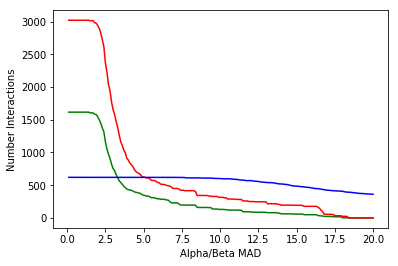

In [421]:
print interval
plt.plot(interval,i_count,c='green')
plt.plot(interval,d_count,c='red')
plt.plot(interval,e_count,c='blue')
#plt.legend(['Increasing','Decreasing','Emergent'])
plt.xlabel('Alpha/Beta MAD')
plt.ylabel('Number Interactions')
plt.show()

In [414]:
print InteractionCount

4873
